In [2]:
# %load Holefill.py
from PIL import Image, ImageDraw
import numpy as np
import random
import os.path
import pickle


# When I use load to make file from py to ipynb, there is something I fixed by hand: print, rowinput->input

In [15]:
##############################################################################
#                            Some helper functions                           #
##############################################################################

def DrawBox(im,x1,y1,x2,y2):
	draw = ImageDraw.Draw(im)
	draw.line((x1,y1,x1,y2),fill="white",width=1)
	draw.line((x1,y1,x2,y1),fill="white",width=1)
	draw.line((x2,y2,x1,y2),fill="white",width=1)
	draw.line((x2,y2,x2,y1),fill="white",width=1)
	del draw
	return im

def Find_Edge(hole_mask):
	[cols, rows] = np.shape(hole_mask)
	edge_mask = np.zeros(np.shape(hole_mask))
	for y in range(rows):
		for x in range(cols):
			if (hole_mask[x,y] == 1):
				if (hole_mask[x-1,y] == 0 or
						hole_mask[x+1,y] == 0 or
						hole_mask[x,y-1] == 0 or
						hole_mask[x,y+1] == 0):
					edge_mask[x,y] = 1
	return edge_mask

# 4 
You need to write a function ComputeSSD that computes the sum squared difference (SSD) between an image patch and the texture image, for each possible location of the patch within the texture image. It must ignore empty pixels that have a value of 1 in the given mask image. Skeleton code for this function is provided in Holefill.py.

HINTS: 
1. The image patch is called TODOPatch, and it is a square patch of size [2 * patchL + 1, 2 * patchL + 1, 3]. Note that the final dimension of 3 means that there are 3 colour values for each pixel. 
2. The texture image, textureIm, is of size [texImRows, texImCols, 3]. 
3. There is also a mask (an image of 1s and 0s) that specifies which elements in TODOPatch are empty and waiting to be filled in. The mask is called TODOMask and it contains a 1 for each empty pixel and a 0 for each pixel that has a useful value. Its first 2 dimensions are the same as TODOPatch, but it does not have the third dimension. 
4. You must ignore the empty pixels when computing the result. 
5. Note that the result, ssdIm, will have size [texImRows - 2 * patchL, texImCols - 2 * patchL] because it is only defined where the patch completely overlaps the texture. 
6. Further note that, as given in Holefill.py, the TODOPatch and textureIm arguments to ComputeSSD have data type unit8. This is not a suitable data type for computing the required SSD. A simple Python trick to coerce a number to floating point is to multiply it by 1.0. Do this, in ComputeSSD, as needed.

In [28]:
##############################################################################
#                        Functions for you to complete                       #
##############################################################################

def ComputeSSD(TODOPatch, TODOMask, textureIm, patchL):
    patch_rows, patch_cols, patch_bands = np.shape(TODOPatch)
    tex_rows, tex_cols, tex_bands = np.shape(textureIm)
    ssd_rows = tex_rows - 2 * patchL
    ssd_cols = tex_cols - 2 * patchL
    SSD = np.zeros((ssd_rows,ssd_cols))
    for r in range(ssd_rows):
        for c in range(ssd_cols):
            # Compute sum square difference between textureIm and TODOPatch
            # for all pixels where TODOMask = 0, and store the result in SSD
            #ADD YOUR CODE HERE
            total = 0
            for i in range(patch_rows):
                for j in range(patch_cols):
                    for b in range(patch_bands):
                        if TODOMask[i][j]== 0 :
                            maskedPatch = TODOPatch[i][j][b] * 1.0
                            texture = textureIm[i+r][j+c][b] *1.0
                            total += (maskedPatch - texture)**2
            SSD[r][c] = total                
    return SSD

# 5
The next section of Holefill.py takes the SSD image created above and chooses randomly amongst the best matching patches to decide which patch to paste into the texture image at that point. Next you need to write a functon CopyPatch which copies this selected patch into the final image. Remember again that you should only copy pixel values into the hole section of the image. Existing pixel values should not be overwritten. Skeleton code for CopyPatch is provided in Holefill.py, along with comments explaining the arguments.

Note that this technique of copying a whole patch is much faster than copying just the center pixel as suggested in the original Efros and Leung paper. However, the results are not quite as good. We are also ignoring the use of a Gaussian weighted window as described in their paper.

Hand in a printed copy of the donkey image after texture synthesis has been used to remove the donkey.

In [45]:
def CopyPatch(imHole,TODOMask,textureIm,iPatchCenter,jPatchCenter,iMatchCenter,jMatchCenter,patchL):
    patchSize = 2 * patchL + 1
    for i in range(patchSize):
        for j in range(patchSize):
            # Copy the selected patch selectPatch into the image containing
            # the hole imHole for each pixel where TODOMask = 1.
            # The patch is centred on iPatchCenter, jPatchCenter in the image imHole
            # ADD YOUR CODE HERE
            #
            if TODOMask[i][j] == 1 :
                xm = iMatchCenter - patchL + i
                ym = jMatchCenter - patchL + j
                xp = iPatchCenter - patchL + i
                yp = jPatchCenter - patchL + j
                imHole[xp][yp] = textureIm[xm][ym]
    return imHole

In [61]:
##############################################################################
#                           Main script starts here                          #
##############################################################################

#
# Constants
#

# Change patchL to change the patch size used (patch size is 2 *patchL + 1)
patchL = 10
patchSize = 2*patchL+1

# Standard deviation for random patch selection
randomPatchSD = 1

# Display results interactively
showResults = True

#
# Read input image
#

im = Image.open('donkey.jpg').convert('RGB')
im_array = np.asarray(im, dtype=np.uint8)
imRows, imCols, imBands = np.shape(im_array)

#
# Define hole and texture regions.  This will use files fill_region.pkl and
#   texture_region.pkl, if both exist, otherwise user has to select the regions.
if os.path.isfile('fill_region.pkl') and os.path.isfile('texture_region.pkl'):
	fill_region_file = open('fill_region.pkl', 'rb')
	fillRegion = pickle.load( fill_region_file )
	fill_region_file.close()

	texture_region_file = open('texture_region.pkl', 'rb')
	textureRegion = pickle.load( texture_region_file )
	texture_region_file.close()
else:
	# ask the user to define the regions
	print ("Specify the fill and texture regions using polyselect.py")
	exit()

#
# Get coordinates for hole and texture regions
#

fill_indices = fillRegion.nonzero()
nFill = len(fill_indices[0])                # number of pixels to be filled
iFillMax = max(fill_indices[0])
iFillMin = min(fill_indices[0])
jFillMax = max(fill_indices[1])
jFillMin = min(fill_indices[1])
assert((iFillMin >= patchL) and
		(iFillMax < imRows - patchL) and
		(jFillMin >= patchL) and
		(jFillMax < imCols - patchL)) , "Hole is too close to edge of image for this patch size"

texture_indices = textureRegion.nonzero()
iTextureMax = max(texture_indices[0])
iTextureMin = min(texture_indices[0])
jTextureMax = max(texture_indices[1])
jTextureMin = min(texture_indices[1])
textureIm   = im_array[iTextureMin:iTextureMax+1, jTextureMin:jTextureMax+1, :]
texImRows, texImCols, texImBands = np.shape(textureIm)
assert((texImRows > patchSize) and
		(texImCols > patchSize)) , "Texture image is smaller than patch size"

#
# Initialize imHole for texture synthesis (i.e., set fill pixels to 0)
#

imHole = im_array.copy()
imHole[fill_indices] = 0

#
# Is the user happy with fillRegion and textureIm?
#
if showResults == True:
	# original
	im.show()
	# convert to a PIL image, show fillRegion and draw a box around textureIm
	im1 = Image.fromarray(imHole).convert('RGB')
	im1 = DrawBox(im1,jTextureMin,iTextureMin,jTextureMax,iTextureMax)
	im1.show()
	print("Are you happy with this choice of fillRegion and textureIm?")
	Yes_or_No = False
	while not Yes_or_No:
		answer = input("Yes or No: ")
		if answer == "Yes" or answer == "No":
			Yes_or_No = True
	assert answer == "Yes", "You must be happy. Please try again."

#
# Perform the hole filling
#

while (nFill > 0):
	print("Number of pixels remaining = " , nFill)

	# Set TODORegion to pixels on the boundary of the current fillRegion
	TODORegion = Find_Edge(fillRegion)
	edge_pixels = TODORegion.nonzero()
	nTODO = len(edge_pixels[0])

	while(nTODO > 0):

		# Pick a random pixel from the TODORegion
		index = np.random.randint(0,nTODO)
		iPatchCenter = edge_pixels[0][index]
		jPatchCenter = edge_pixels[1][index]

		# Define the coordinates for the TODOPatch
		TODOPatch = imHole[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1,:]
		TODOMask = fillRegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1]

		#
		# Compute masked SSD of TODOPatch and textureIm
		#
		ssdIm = ComputeSSD(TODOPatch, TODOMask, textureIm, patchL)

		# Randomized selection of one of the best texture patches
		ssdIm1 = np.sort(np.copy(ssdIm),axis=None)
		ssdValue = ssdIm1[min(round(abs(random.gauss(0,randomPatchSD))),np.size(ssdIm1)-1)]
		ssdIndex = np.nonzero(ssdIm==ssdValue)
		iSelectCenter = ssdIndex[0][0]
		jSelectCenter = ssdIndex[1][0]

		# adjust i, j coordinates relative to textureIm
		iSelectCenter = iSelectCenter + patchL
		jSelectCenter = jSelectCenter + patchL
		selectPatch = textureIm[iSelectCenter-patchL:iSelectCenter+patchL+1,jSelectCenter-patchL:jSelectCenter+patchL+1,:]

		#
		# Copy patch into hole
		#
		imHole = CopyPatch(imHole,TODOMask,textureIm,iPatchCenter,jPatchCenter,iSelectCenter,jSelectCenter,patchL)

		# Update TODORegion and fillRegion by removing locations that overlapped the patch
		TODORegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1] = 0
		fillRegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1] = 0

		edge_pixels = TODORegion.nonzero()
		nTODO = len(edge_pixels[0])

	fill_indices = fillRegion.nonzero()
	nFill = len(fill_indices[0])

#
# Output results
#
if showResults == True:
	Image.fromarray(imHole).convert('RGB').show()
Image.fromarray(imHole).convert('RGB').save('results.jpg')

Are you happy with this choice of fillRegion and textureIm?
Yes or No: Yes
Number of pixels remaining =  3473
Number of pixels remaining =  1044
Number of pixels remaining =  47


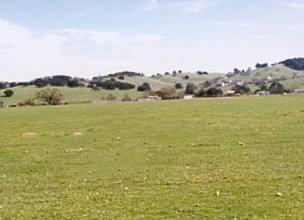

In [62]:
# show the result
im = Image.open("results.jpg")
display(im)

# 6 
Try running this texture synthesis method on some new images of your choosing. You will need to indicate the area of the removed region in the code. You can load your own image by altering the line that reads donkey.jpg in Holefill.py. You will need to select small regions to avoid long run times.

You can specify the fill and texture regions yourself by typing

	        
        python polyselect.py
        
    
at the command prompt. The donkey image will be displayed. You draw a polygon by selecting each successive vertex with a mouse click. Close the display window to complete and save the polygon. To try another image, you will have to alter the variable imname around line 90. Regions you specify yourself will be saved for subsequent use as the files fill_region.pkl and texture_region.pkl, overwriting existing files with the same name. Note: Be sure to save copies of the original fill_region.pkl and texture_region.pkl files.

Take a look at the code which randomly selects from the best matching patches. This takes an argument randomPatchSD which is the standard deviation of the number of the patch that gets chosen. If this value is set to 0, then the optimal patch (minimum of the ssd image) is always chosen. If this value is large, then the patch choice will be more random. Experiment with this value and with patchL which defines the size of the synthesis patches.

Hand in texture synthesis results for 2 new images, where one shows the algorithm performing well and the other shows it performing poorly. For each example, show both the original image and the modified one. You do not need to print in colour. Briefly describe why the method failed in the case in which it performed poorly.

In [77]:
##############################################################################
#                           Main script starts here                          #
##############################################################################

#
# Constants
#

# Change patchL to change the patch size used (patch size is 2 *patchL + 1)
patchL = 2
patchSize = 2*patchL+1

# Standard deviation for random patch selection
randomPatchSD = 1

# Display results interactively
showResults = True

#
# Read input image
#

# im = Image.open('donkey.jpg').convert('RGB')
im = Image.open('bol.jpg').convert('RGB')
im_array = np.asarray(im, dtype=np.uint8)
imRows, imCols, imBands = np.shape(im_array)

#
# Define hole and texture regions.  This will use files fill_region.pkl and
#   texture_region.pkl, if both exist, otherwise user has to select the regions.
if os.path.isfile('fill_region.pkl') and os.path.isfile('texture_region.pkl'):
	fill_region_file = open('fill_region.pkl', 'rb')
	fillRegion = pickle.load( fill_region_file )
	fill_region_file.close()

	texture_region_file = open('texture_region.pkl', 'rb')
	textureRegion = pickle.load( texture_region_file )
	texture_region_file.close()
else:
	# ask the user to define the regions
	print ("Specify the fill and texture regions using polyselect.py")
	exit()

#
# Get coordinates for hole and texture regions
#

fill_indices = fillRegion.nonzero()
nFill = len(fill_indices[0])                # number of pixels to be filled
iFillMax = max(fill_indices[0])
iFillMin = min(fill_indices[0])
jFillMax = max(fill_indices[1])
jFillMin = min(fill_indices[1])
assert((iFillMin >= patchL) and
		(iFillMax < imRows - patchL) and
		(jFillMin >= patchL) and
		(jFillMax < imCols - patchL)) , "Hole is too close to edge of image for this patch size"

texture_indices = textureRegion.nonzero()
iTextureMax = max(texture_indices[0])
iTextureMin = min(texture_indices[0])
jTextureMax = max(texture_indices[1])
jTextureMin = min(texture_indices[1])
textureIm   = im_array[iTextureMin:iTextureMax+1, jTextureMin:jTextureMax+1, :]
texImRows, texImCols, texImBands = np.shape(textureIm)
assert((texImRows > patchSize) and
		(texImCols > patchSize)) , "Texture image is smaller than patch size"

#
# Initialize imHole for texture synthesis (i.e., set fill pixels to 0)
#

imHole = im_array.copy()
imHole[fill_indices] = 0

#
# Is the user happy with fillRegion and textureIm?
#
if showResults == True:
	# original
	im.show()
	# convert to a PIL image, show fillRegion and draw a box around textureIm
	im1 = Image.fromarray(imHole).convert('RGB')
	im1 = DrawBox(im1,jTextureMin,iTextureMin,jTextureMax,iTextureMax)
	im1.show()
	print("Are you happy with this choice of fillRegion and textureIm?")
	Yes_or_No = False
	while not Yes_or_No:
		answer = input("Yes or No: ")
		if answer == "Yes" or answer == "No":
			Yes_or_No = True
	assert answer == "Yes", "You must be happy. Please try again."

#
# Perform the hole filling
#

while (nFill > 0):
    print("Number of pixels remaining = " , nFill)
    # Set TODORegion to pixels on the boundary of the current fillRegion
    TODORegion = Find_Edge(fillRegion)
    edge_pixels = TODORegion.nonzero()
    nTODO = len(edge_pixels[0])

    while(nTODO > 0):

        # Pick a random pixel from the TODORegion
        index = np.random.randint(0,nTODO)
        iPatchCenter = edge_pixels[0][index]
        jPatchCenter = edge_pixels[1][index]

        # Define the coordinates for the TODOPatch
        TODOPatch = imHole[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1,:]
        TODOMask = fillRegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1]

        #
        # Compute masked SSD of TODOPatch and textureIm
        #
        ssdIm = ComputeSSD(TODOPatch, TODOMask, textureIm, patchL)

        # Randomized selection of one of the best texture patches
        ssdIm1 = np.sort(np.copy(ssdIm),axis=None)
        ssdValue = ssdIm1[min(round(abs(random.gauss(0,randomPatchSD))),np.size(ssdIm1)-1)]
        ssdIndex = np.nonzero(ssdIm==ssdValue)
        iSelectCenter = ssdIndex[0][0]
        jSelectCenter = ssdIndex[1][0]

        # adjust i, j coordinates relative to textureIm
        iSelectCenter = iSelectCenter + patchL
        jSelectCenter = jSelectCenter + patchL
        selectPatch = textureIm[iSelectCenter-patchL:iSelectCenter+patchL+1,jSelectCenter-patchL:jSelectCenter+patchL+1,:]

        #
        # Copy patch into hole
        #
        imHole = CopyPatch(imHole,TODOMask,textureIm,iPatchCenter,jPatchCenter,iSelectCenter,jSelectCenter,patchL)

        # Update TODORegion and fillRegion by removing locations that overlapped the patch
        TODORegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1] = 0
        fillRegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1] = 0
        edge_pixels = TODORegion.nonzero()
        nTODO = len(edge_pixels[0])

    fill_indices = fillRegion.nonzero()
    nFill = len(fill_indices[0])

#
# Output results
#
if showResults == True:
    Image.fromarray(imHole).convert('RGB').show()
Image.fromarray(imHole).convert('RGB').save('results2.jpg')

Are you happy with this choice of fillRegion and textureIm?
Yes or No: Yes
Number of pixels remaining =  2005
Number of pixels remaining =  1521
Number of pixels remaining =  1116
Number of pixels remaining =  774
Number of pixels remaining =  483
Number of pixels remaining =  255
Number of pixels remaining =  91


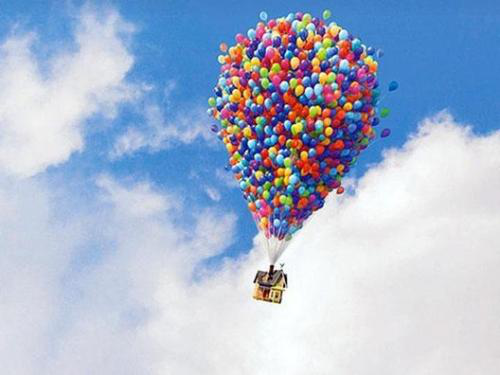

In [74]:
# Original
im = Image.open("bol.jpg")
display(im)

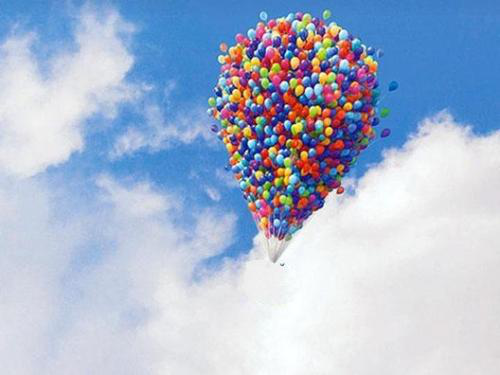

In [76]:
# With patchL = 2   randomPatchSD = 1
im = Image.open("results1.jpg")
display(im)

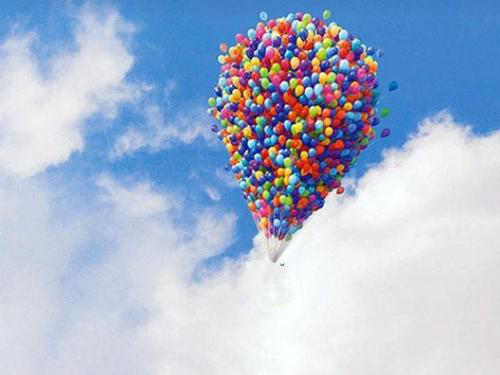

In [75]:
# # With patchL = 10   randomPatchSD = 2
im = Image.open("results2.jpg")
display(im)

smaller patchL makes the filling not natural, the second pair of value is better.

In [84]:
##############################################################################
#                           Main script starts here                          #
##############################################################################

#
# Constants
#

# Change patchL to change the patch size used (patch size is 2 *patchL + 1)
patchL = 1
patchSize = 2*patchL+1

# Standard deviation for random patch selection
randomPatchSD = 1

# Display results interactively
showResults = True

#
# Read input image
#

# im = Image.open('donkey.jpg').convert('RGB')
im = Image.open('oak.png').convert('RGB')
im_array = np.asarray(im, dtype=np.uint8)
imRows, imCols, imBands = np.shape(im_array)

#
# Define hole and texture regions.  This will use files fill_region.pkl and
#   texture_region.pkl, if both exist, otherwise user has to select the regions.
if os.path.isfile('fill_region.pkl') and os.path.isfile('texture_region.pkl'):
	fill_region_file = open('fill_region.pkl', 'rb')
	fillRegion = pickle.load( fill_region_file )
	fill_region_file.close()

	texture_region_file = open('texture_region.pkl', 'rb')
	textureRegion = pickle.load( texture_region_file )
	texture_region_file.close()
else:
	# ask the user to define the regions
	print ("Specify the fill and texture regions using polyselect.py")
	exit()

#
# Get coordinates for hole and texture regions
#

fill_indices = fillRegion.nonzero()
nFill = len(fill_indices[0])                # number of pixels to be filled
iFillMax = max(fill_indices[0])
iFillMin = min(fill_indices[0])
jFillMax = max(fill_indices[1])
jFillMin = min(fill_indices[1])
assert((iFillMin >= patchL) and
		(iFillMax < imRows - patchL) and
		(jFillMin >= patchL) and
		(jFillMax < imCols - patchL)) , "Hole is too close to edge of image for this patch size"

texture_indices = textureRegion.nonzero()
iTextureMax = max(texture_indices[0])
iTextureMin = min(texture_indices[0])
jTextureMax = max(texture_indices[1])
jTextureMin = min(texture_indices[1])
textureIm   = im_array[iTextureMin:iTextureMax+1, jTextureMin:jTextureMax+1, :]
texImRows, texImCols, texImBands = np.shape(textureIm)
assert((texImRows > patchSize) and
		(texImCols > patchSize)) , "Texture image is smaller than patch size"

#
# Initialize imHole for texture synthesis (i.e., set fill pixels to 0)
#

imHole = im_array.copy()
imHole[fill_indices] = 0

#
# Is the user happy with fillRegion and textureIm?
#
if showResults == True:
	# original
	im.show()
	# convert to a PIL image, show fillRegion and draw a box around textureIm
	im1 = Image.fromarray(imHole).convert('RGB')
	im1 = DrawBox(im1,jTextureMin,iTextureMin,jTextureMax,iTextureMax)
	im1.show()
	print("Are you happy with this choice of fillRegion and textureIm?")
	Yes_or_No = False
	while not Yes_or_No:
		answer = input("Yes or No: ")
		if answer == "Yes" or answer == "No":
			Yes_or_No = True
	assert answer == "Yes", "You must be happy. Please try again."

#
# Perform the hole filling
#

while (nFill > 0):
    print("Number of pixels remaining = " , nFill)
    # Set TODORegion to pixels on the boundary of the current fillRegion
    TODORegion = Find_Edge(fillRegion)
    edge_pixels = TODORegion.nonzero()
    nTODO = len(edge_pixels[0])

    while(nTODO > 0):

        # Pick a random pixel from the TODORegion
        index = np.random.randint(0,nTODO)
        iPatchCenter = edge_pixels[0][index]
        jPatchCenter = edge_pixels[1][index]

        # Define the coordinates for the TODOPatch
        TODOPatch = imHole[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1,:]
        TODOMask = fillRegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1]

        #
        # Compute masked SSD of TODOPatch and textureIm
        #
        ssdIm = ComputeSSD(TODOPatch, TODOMask, textureIm, patchL)

        # Randomized selection of one of the best texture patches
        ssdIm1 = np.sort(np.copy(ssdIm),axis=None)
        ssdValue = ssdIm1[min(round(abs(random.gauss(0,randomPatchSD))),np.size(ssdIm1)-1)]
        ssdIndex = np.nonzero(ssdIm==ssdValue)
        iSelectCenter = ssdIndex[0][0]
        jSelectCenter = ssdIndex[1][0]

        # adjust i, j coordinates relative to textureIm
        iSelectCenter = iSelectCenter + patchL
        jSelectCenter = jSelectCenter + patchL
        selectPatch = textureIm[iSelectCenter-patchL:iSelectCenter+patchL+1,jSelectCenter-patchL:jSelectCenter+patchL+1,:]

        #
        # Copy patch into hole
        #
        imHole = CopyPatch(imHole,TODOMask,textureIm,iPatchCenter,jPatchCenter,iSelectCenter,jSelectCenter,patchL)

        # Update TODORegion and fillRegion by removing locations that overlapped the patch
        TODORegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1] = 0
        fillRegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1] = 0
        edge_pixels = TODORegion.nonzero()
        nTODO = len(edge_pixels[0])

    fill_indices = fillRegion.nonzero()
    nFill = len(fill_indices[0])

#
# Output results
#
if showResults == True:
    Image.fromarray(imHole).convert('RGB').show()
Image.fromarray(imHole).convert('RGB').save('results3.jpg')

Are you happy with this choice of fillRegion and textureIm?
Yes or No: Yes
Number of pixels remaining =  1796
Number of pixels remaining =  1344
Number of pixels remaining =  927
Number of pixels remaining =  543
Number of pixels remaining =  200
Number of pixels remaining =  13


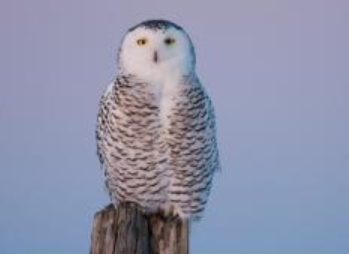

In [86]:
# Original
im = Image.open("oak.png")
display(im)

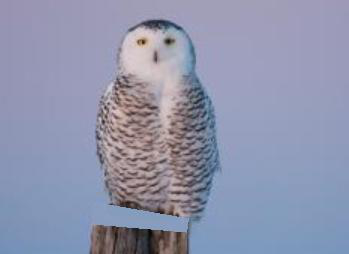

In [87]:
# With patchL = 2   randomPatchSD = 1
im = Image.open("results3.jpg")
display(im)

# 7
Provide an explanation for the effects of the randomPatchSD and patchL parameters. What results can be expected if these values are too small or too large, and why do these results happen?

 randomPatchSD is the standard deviation of the number of the patch that gets chosen. We use it to choose a patch randomly to fill the hole among patches whose standrand deviation is low. 
1. If randomPatchSD is too small, then the minimum of ssd image is always chosen, limited randomness will result in unexpected filling.
2. If randomPatchSD is too large, more randomable, but the pathches that not fill well are also be chosen unaviodably.
 
patchL is the size of patch. It dependes on the area we chose.
1. If patch is too small, the character of the chosen patch will be missed since it is limited area, the filling may be not satisfying. 
2. If patch is too large,it may aviod the requirement: not close to the edge. Also it will make the filling too general, it is hard to find good path to filling in. 